# Neural Machine Translation

![](https://tsdaemon.github.io/assets/images/nmt/Seq2Seq-thought-vector.png)

# Data collection and Preprocessing

In [1]:
import subprocess
import os
import pandas as pd

#ISO 639-3 code for a source languages
source_lang = 'eng'
target_lang = 'swh'
data_dir = './'

# Download sentences if not already present
sentences_path = os.path.join(data_dir, 'sentences.csv')
if not os.path.isfile(sentences_path):
    if not os.path.isfile(os.path.join(data_dir, 'sentences.tar.bz2')):
        subprocess.run(
            "wget https://downloads.tatoeba.org/exports/sentences.tar.bz2 -P " + data_dir,
            shell=True)

    subprocess.run(
        "tar xvjC {0} -f {0}/sentences.tar.bz2".format(data_dir), shell=True)

# Download links if not already present
links_path = os.path.join(data_dir, 'links.csv')
if not os.path.isfile(links_path):
    if not os.path.isfile(os.path.join(data_dir, 'links.tar.bz2')):
        subprocess.run(
            "wget https://downloads.tatoeba.org/exports/links.tar.bz2 -P " + data_dir,
            shell=True)

    subprocess.run("tar xvjC {0} -f {0}/links.tar.bz2".format(data_dir), shell=True)

# Read the datasets
sentences = pd.read_csv(sentences_path, names=['id', 'lang', 'text'], header=None, delimiter='\t')
links = pd.read_csv(links_path, names=['sent_id', 'tran_id'], header=None, delimiter='\t')

# Filter for source (English) and target (Swahili) sentences
source_sentences = sentences[sentences.lang == source_lang]
source_sentences = source_sentences.merge(links, left_on='id', right_on='sent_id')
target_sentences = sentences[sentences.lang == target_lang]

bilang_sentences = source_sentences.merge(target_sentences, left_on='tran_id',
                                          right_on='id',
                                          suffixes=[source_lang, target_lang])
bilang_sentences = bilang_sentences[['text' + source_lang, 'text' + target_lang]]

# Save results
file_name = os.path.join(data_dir, '{source}-{target}.csv'.format(source=source_lang, target=target_lang))
bilang_sentences.to_csv(file_name, index=False, sep='\t')

In [2]:
corpus = pd.read_csv(os.path.join(data_dir, '{}-{}.csv'.format(source_lang, target_lang)), delimiter='\t')

In [3]:
print("Original Corpus Length:", len(corpus))
corpus = corpus[1:10000]
print("Reduced Corpus Length:", len(corpus))

Original Corpus Length: 4293
Reduced Corpus Length: 4292


In [4]:
corpus.head()

,texteng,textswh
1,You wanted to tell me about freedom?,Ulitaka kunieleza kuhusu uhuru?
2,I love you.,Nakupenda.
3,I have a headache.,Kichwa kinauma.
4,"Where there's a will, there's a way.","Penye nia, pana njia."
5,I don't want to go to school.,Sitaki kwenda shule.


# Vocabulary Class for token management

In [5]:
SOS_token = '<start>'
EOS_token = '<end>'
UNK_token = '<unk>'
PAD_token = '<pad>'

SOS_idx = 0
EOS_idx = 1
UNK_idx = 2
PAD_idx = 3

# Vocabulary Class
class Vocab:
    def __init__(self):
        self.index2word = {
            SOS_idx: SOS_token,
            EOS_idx: EOS_token,
            UNK_idx: UNK_token,
            PAD_idx: PAD_token
        }
        self.word2index = {v: k for k, v in self.index2word.items()}

    def index_words(self, words):
        for word in words:
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            new_index = len(self)
            self.word2index[word] = new_index
            self.index2word[new_index] = word

    def __len__(self):
        assert len(self.index2word) == len(self.word2index)
        return len(self.index2word)

    def unidex_words(self, indices):
        return [self.index2word.get(i, UNK_token) for i in indices]

    def to_file(self, filename):
        words = [w for w, _ in sorted(list(self.word2index.items())[4:])]  # Exclude special tokens
        with open(filename, 'w') as f:
            f.write('\n'.join(words))

    @classmethod
    def from_file(cls, filename):
        vocab = cls()
        with open(filename, 'r') as f:
            words = [line.strip() for line in f.readlines()]
            vocab.index_words(words)
        return vocab

# Tokenize the data

In [6]:
import nltk
import pandas as pd
import os

max_length = 10
min_word_count = 1

tokenizers = {
    'eng': nltk.tokenize.WordPunctTokenizer().tokenize,
    'swh': nltk.tokenize.WordPunctTokenizer().tokenize
}

def preprocess_corpus(sents, tokenizer, min_word_count):
    word_counts = {}
    tokenized_sentences = []

    for sent in sents:
        tokens = [w.lower() for w in tokenizer(sent)]
        tokenized_sentences.append(tokens)

        for word in tokens:
            word_counts[word] = word_counts.get(word, 0) + 1

    for i, tokens in enumerate(tokenized_sentences):
        tokenized_sentences[i] = [t if word_counts[t] >= min_word_count else UNK_token for t in tokens]

    return tokenized_sentences

def read_vocab(sentences):
    vocab = Vocab()
    for sentence in sentences:
        vocab.index_words(sentence)
    return vocab

source_sents = preprocess_corpus(corpus['texteng'], tokenizers['eng'], min_word_count)
target_sents = preprocess_corpus(corpus['textswh'], tokenizers['swh'], min_word_count)

source_sents, target_sents = zip(
    *sorted({(tuple(src), tuple(tgt)) for src, tgt in zip(source_sents, target_sents)
             if len(src) <= max_length and len(tgt) <= max_length})
)

source_vocab = read_vocab(source_sents)
target_vocab = read_vocab(target_sents)

source_vocab.to_file(os.path.join(data_dir, f'{source_lang}.vocab.txt'))
target_vocab.to_file(os.path.join(data_dir, f'{target_lang}.vocab.txt'))

print(f'Corpus Length: {len(source_sents)}')
print(f'Source Vocabulary Size (English): {len(source_vocab.word2index)}')
print(f'Target Vocabulary Size (Swahili): {len(target_vocab.word2index)}')

examples = list(zip(source_sents, target_sents))[80:90]
for source, target in examples:
    print(f'Source: "{" ".join(source)}", Target: "{" ".join(target)}"')

Corpus Length: 2306
Source Vocabulary Size (English): 3345
Target Vocabulary Size (Swahili): 3955
Source: "as usual , he reads the newspaper while eating .", Target: "kama kawaida , anasoma gazeti akila ."
Source: "at seven i ' ll be back .", Target: "saa saba nitakuwa nimerejea ."
Source: "attack is the best form of defense .", Target: "mashambulizi ni aina bora ya utetezi ."
Source: "auto - destruct sequence armed .", Target: "mfuatano wa uharibifu wa kiotamatiki umejihami na silaha ."
Source: "aww , they look so cute together .", Target: "aww , wanakaa vizuri sana pamoja ."
Source: "babies want plenty of sleep .", Target: "watata wanafaa kulala sana ."
Source: "base jumping is an extreme sport .", Target: "kuruka kwa msingi ni mchezo uliokithiri ."
Source: "basically , you ' re absolutely right .", Target: "kimsingi , wewe ni sawa kabisa ."
Source: "be seen by me !", Target: "niangalie !"
Source: "beat the egg before putting it in the soup .", Target: "twanga yai kabla ya kuliweka k

In [7]:
source_to_target = {}
for source, target in zip(source_sents, target_sents):
    if source in source_to_target:
        source_to_target[source].append(target)
    else:
        source_to_target[source] = [target]

source_sents, target_sents = zip(*source_to_target.items())

print(f"Total Unique Source Sentences: {len(source_sents)}")

Total Unique Source Sentences: 2293


# Split the data

In [8]:
import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

source_length = len(source_sents)
indices = np.random.permutation(source_length)

training_indices = indices[:int(source_length*0.8)]         # 80% for training
dev_indices = indices[int(source_length*0.8):int(source_length*0.86)]         # 6% for development
test_indices = indices[int(source_length*0.86):]          # 14% for testing

training_source = [source_sents[i] for i in training_indices]
dev_source = [source_sents[i] for i in dev_indices]
test_source = [source_sents[i] for i in test_indices]

training_target = [target_sents[i] for i in training_indices]
dev_target = [target_sents[i] for i in dev_indices]
test_target = [target_sents[i] for i in test_indices]

training_s = []
training_t = []
for source, target_list in zip(training_source, training_target):
    for target in target_list:
        training_s.append(source)
        training_t.append(target)

training_source = training_s
training_target = training_t

print(f"Training Set Size: {len(training_source)}")
print(f"Development Set Size: {len(dev_source)}")
print(f"Test Set Size: {len(test_source)}")

Training Set Size: 1844
Development Set Size: 137
Test Set Size: 322


# Pad sequences & convert to Tensors

In [9]:
import torch

def indexes_from_sentence(vocab, sentence):
    return [vocab.word2index[word] for word in sentence]

def tensor_from_sentence(vocab, sentence, max_seq_length):
    indexes = indexes_from_sentence(vocab, sentence)
    indexes.append(EOS_idx)
    indexes.insert(0, SOS_idx)

    # Pad sequences to uniform length
    if len(indexes) < max_seq_length:
        indexes += [PAD_idx] * (max_seq_length - len(indexes))
    return torch.LongTensor(indexes)

def tensors_from_pair(source_sent, target_sent, max_seq_length):
    source_tensor = tensor_from_sentence(source_vocab, source_sent, max_seq_length).unsqueeze(1)
    target_tensor = tensor_from_sentence(target_vocab, target_sent, max_seq_length).unsqueeze(1)
    return (source_tensor, target_tensor)

max_seq_length = max_length + 2

# Prepare training data
training = [tensors_from_pair(source_sent, target_sent, max_seq_length)
            for source_sent, target_sent in zip(training_source, training_target)]

# Organize data into tensors
x_training, y_training = zip(*training)
x_training = torch.transpose(torch.cat(x_training, dim=-1), 1, 0)
y_training = torch.transpose(torch.cat(y_training, dim=-1), 1, 0)

# Save training data
torch.save(x_training, os.path.join(data_dir, 'x_training.bin'))
torch.save(y_training, os.path.join(data_dir, 'y_training.bin'))

# Prepare development data
x_development = [tensor_from_sentence(source_vocab, source_sent, max_seq_length).unsqueeze(1)
                 for source_sent in dev_source]
x_development = torch.transpose(torch.cat(x_development, dim=-1), 1, 0)
torch.save(x_development, os.path.join(data_dir, 'x_development.bin'))

# Prepare test data
x_test = [tensor_from_sentence(source_vocab, source_sent, max_seq_length).unsqueeze(1)
          for source_sent in test_source]
x_test = torch.transpose(torch.cat(x_test, dim=-1), 1, 0)
torch.save(x_test, os.path.join(data_dir, 'x_test.bin'))

# Optional: Move tensors to GPU if CUDA is enabled
USE_CUDA = False
if USE_CUDA:
    model = model.cuda()
    x_training = x_training.cuda()
    y_training = y_training.cuda()
    x_development = x_development.cuda()
    x_test = x_test.cuda()

# Display data shapes for confirmation
print(f"x_training shape: {x_training.shape}")
print(f"y_training shape: {y_training.shape}")
print(f"x_development shape: {x_development.shape}")
print(f"x_test shape: {x_test.shape}")

x_training shape: torch.Size([1844, 12])
y_training shape: torch.Size([1844, 12])
x_development shape: torch.Size([137, 12])
x_test shape: torch.Size([322, 12])


# Model

The encoder of an Encoder-Decoder network is a Recurrent Neural Network. A recurrent network can model a sequence of related data (sentence in our case) using the same set of weights. To do this, RNN uses its output from a previous step as input along with the next input from a sequence.

A naive implementation of RNN is subject to problems with a gradient for long sequences; therefore, I used LSTM as a recurrent module. You should not care about its implementation since it already implemented in PyTorch: nn.LSTM. This module allows bi-directional sequence processing out-of-the-box – this allows to capture backward relations in a sentence as well as forward relations.

Additionally, I used embeddings module to convert word indices into dense vectors. This allows projecting discrete symbols (words) into continuous space which reflects semantical relations in spatial words positions. For this experiment, I did not use pre-trained word vectors and trained this representation using machine translation supervision signal. But you may use the pre-trained word embeddings for any language.

# Encoder

In [10]:
import torch.nn as nn
import torch.nn.init as init

class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        init.normal_(self.embedding.weight, 0.0, 0.2)

        self.lstm = nn.LSTM(
            hidden_size,
            int(hidden_size/2),  # Bi-directional processing will ouput vectors of double size, therefore I reduced output dimensionality
            num_layers=n_layers,
            dropout=0.3,
            batch_first=True,  # First dimension of input tensor will be treated as a batch dimension
            bidirectional=True
        )

    # word_inputs: (batch_size, seq_length), h: (h_or_c, layer_n_direction, batch, seq_length)
    def forward(self, word_inputs, hidden):
        # embedded (batch_size, seq_length, hidden_size)
        embedded = self.embedding(word_inputs)
        # output (batch_size, seq_length, hidden_size*directions)
        # hidden (h: (num_layers*directions, batch_size, hidden_size),
        #         c: (num_layers*directions, batch_size, hidden_size))
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self, batches):
        #hidden = torch.zeros(2, self.n_layers*2, batches, int(self.hidden_size/2))
        h_s = torch.zeros(self.n_layers*2, batches, int(self.hidden_size/2))
        c_s = torch.zeros(self.n_layers*2, batches, int(self.hidden_size/2))
        hidden = (h_s, c_s)
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

# Decoder

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(DecoderRNN, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        init.normal_(self.embedding.weight, 0.0, 0.2)

        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=n_layers, dropout=0.2, batch_first=True, bidirectional=False)

    def forward(self, word_inputs, hidden):
        # Note: we run this one by one
        # embedded (batch_size, 1, hidden_size)
        embedded = self.embedding(word_inputs).unsqueeze_(1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

# Test with fake data

## Encoder

In [12]:
vocab_size = 10
hidden_dim = 10
n_layers = 2

encoder_test = EncoderRNN(vocab_size, hidden_dim, n_layers)
print(encoder_test)

# Recurrent network requires initial hidden state
encoder_hidden = encoder_test.init_hidden(1)

# Test input of size (1x3), one sequence of size 3
word_input = torch.LongTensor([[1, 2, 3]])

if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()

encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

print(encoder_outputs.shape, encoder_hidden[0].shape, encoder_hidden[1].shape)

EncoderRNN(
  (embedding): Embedding(10, 10)
  (lstm): LSTM(10, 5, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
)
torch.Size([1, 3, 10]) torch.Size([4, 1, 5]) torch.Size([4, 1, 5])


## Decoder Test

In [13]:
decoder_test = DecoderRNN(vocab_size, hidden_dim, n_layers)
print(decoder_test)

word_inputs = torch.LongTensor([[1, 2, 3]])

decoder_hidden_h = encoder_hidden[0].permute(1, 0, 2).reshape(1, 2, 10).permute(1, 0, 2)
decoder_hidden_c = encoder_hidden[1].permute(1, 0, 2).reshape(1, 2, 10).permute(1, 0, 2)

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()

for i in range(3):
    input = word_inputs[:, i]
    decoder_output, decoder_hidden = decoder_test(input, (decoder_hidden_h, decoder_hidden_c))
    decoder_hidden_h, decoder_hidden_c = decoder_hidden
    print(decoder_output.size(), decoder_hidden_h.size(), decoder_hidden_c.size())

DecoderRNN(
  (embedding): Embedding(10, 10)
  (lstm): LSTM(10, 10, num_layers=2, batch_first=True, dropout=0.2)
)
torch.Size([1, 1, 10]) torch.Size([2, 1, 10]) torch.Size([2, 1, 10])
torch.Size([1, 1, 10]) torch.Size([2, 1, 10]) torch.Size([2, 1, 10])
torch.Size([1, 1, 10]) torch.Size([2, 1, 10]) torch.Size([2, 1, 10])


# Seq2Seq

The logic to coordinate this two modules I stored in a high-level module Seq2seq; it takes care of Encoder-Decoder coordination and a transformation of decoder results into a word probability distribution.

Also, this module implements two forward functions: one is for training time and second is for inference. The difference between these two functions is that during training I am using training y values (target sentence words) as decoder input; this is called Teacher Forcing. Obviously, during inference, I don’t have y values, so I need a separate method for it.

In [14]:
class Seq2seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, hidden_size, n_layers):
        super(Seq2seq, self).__init__()

        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.encoder = EncoderRNN(input_vocab_size, hidden_size, self.n_layers)
        self.decoder = DecoderRNN(output_vocab_size, hidden_size, self.n_layers)

        self.W = nn.Linear(hidden_size, output_vocab_size)
        init.normal_(self.W.weight, 0.0, 0.2)

        self.softmax = nn.Softmax(dim=-1)

    def _forward_encoder(self, x):
        batch_size = x.shape[0]
        init_hidden = self.encoder.init_hidden(batch_size)
        encoder_outputs, encoder_hidden = self.encoder(x, init_hidden)
        encoder_hidden_h, encoder_hidden_c = encoder_hidden

        self.decoder_hidden_h = encoder_hidden_h.permute(1,0,2).reshape(batch_size, self.n_layers, self.hidden_size).permute(1,0,2)
        self.decoder_hidden_c = encoder_hidden_c.permute(1,0,2).reshape(batch_size, self.n_layers, self.hidden_size).permute(1,0,2)
        return self.decoder_hidden_h, self.decoder_hidden_c

    def forward_train(self, x, y):
        decoder_hidden_h, decoder_hidden_c = self._forward_encoder(x)

        H = []
        for i in range(y.shape[1]):
            input = y[:, i]
            decoder_output, decoder_hidden = self.decoder(input, (decoder_hidden_h, decoder_hidden_c))
            decoder_hidden_h, decoder_hidden_c = decoder_hidden
            # h: (batch_size, vocab_size)
            h = self.W(decoder_output.squeeze(1))
            # h: (batch_size, vocab_size, 1)
            H.append(h.unsqueeze(2))

        # H: (batch_size, vocab_size, seq_len)
        return torch.cat(H, dim=2)

    def forward(self, x):
        decoder_hidden_h, decoder_hidden_c = self._forward_encoder(x)

        current_y = SOS_idx
        result = [current_y]
        counter = 0
        while current_y != EOS_idx and counter < 100:
            input = torch.tensor([current_y])
            decoder_output, decoder_hidden = self.decoder(input, (decoder_hidden_h, decoder_hidden_c))
            decoder_hidden_h, decoder_hidden_c = decoder_hidden
            # h: (vocab_size)
            h = self.W(decoder_output.squeeze(1)).squeeze(0)
            y = self.softmax(h)
            _, current_y = torch.max(y, dim=0)
            current_y = current_y.item()
            result.append(current_y)
            counter += 1

        return result

# Training

In [15]:
from torch.optim import Adam

model = Seq2seq(len(source_vocab), len(target_vocab), 512, 2)
optim = Adam(model.parameters(), lr=0.01)

In [16]:
import math

def batch_generator(batch_indices, batch_size):
    batches = math.ceil(len(batch_indices)/batch_size)
    for i in range(batches):
        batch_start = i*batch_size
        batch_end = (i+1)*batch_size
        if batch_end > len(batch_indices):
            yield batch_indices[batch_start:]
        else:
            yield batch_indices[batch_start:batch_end]

In [17]:
cross_entropy = nn.CrossEntropyLoss()

# Evaluate metrics for Model performance

BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.
Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is" – this is the central idea behind BLEU.
https://www.digitalocean.com/community/tutorials/bleu-score-in-python

In [18]:
from nltk.translate.bleu_score import corpus_bleu

def bleu(n):
    weights = [1.0/n]*n + [0.0]*(4-n)
    return lambda list_of_references, list_of_hypothesis: corpus_bleu(list_of_references, list_of_hypothesis, weights)

def accuracy(list_of_references, list_of_hypothesis):
    total = 0.0
    for references, hypothesis in zip(list_of_references, list_of_hypothesis):
        total += 1.0 if tuple(hypothesis) in set(references) else 0.0
    return total / len(list_of_references)

score_functions = {'BLEU-{}'.format(i):bleu(i) for i in range(1, 5)}
score_functions['Accuracy'] = accuracy

def score(model, X, target, desc='Scoring...'):
    scores = {name:0.0 for name in score_functions.keys()}
    length = len(target)
    list_of_hypothesis = []
    for i, x in tqdm(enumerate(X),
                     desc=desc,
                     total=length):
        y = model(x.unsqueeze(0))
        hypothesis = target_vocab.unidex_words(y[1:-1])  # Remove SOS and EOS from y
        list_of_hypothesis.append(hypothesis)

    for name, func in score_functions.items():
        score = func(target, list_of_hypothesis)
        scores[name] = score

    return scores

# Training the Seq2Seq Model

In [19]:
from tqdm.notebook import tqdm

BATCH_SIZE = 256
total_batches = int(len(x_training)/BATCH_SIZE) + 1
indices = list(range(len(x_training)))

early_stop_after = 50
early_stop_counter = 0
best_model = None

best_score = 0.0
scoring_metric = 'BLEU-1'
scores_history = []
loss_history = []

for epoch in range(80): #1000+
    # Training
    total_loss = 0.0
    for step, batch in tqdm(enumerate(batch_generator(indices, BATCH_SIZE)),
                            desc='Training epoch {}'.format(epoch+1),
                            total=total_batches):
        x = x_training[batch, :]
        # y for teacher forcing is all sequence without a last element
        y_tf = y_training[batch, :-1]
        # y for loss calculation is all sequence without a last element
        y_true = y_training[batch, 1:]
        # (batch_size, vocab_size, seq_length)
        H = model.forward_train(x, y_tf)
        loss = cross_entropy(H, y_true)

        assert loss.item() > 0

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()

    loss_history.append(total_loss/total_batches)
    print('Epoch {} training is finished, loss: {:.4f}'.format(epoch+1, total_loss/total_batches))

    desc = 'Validating epoch {}'.format(epoch+1)
    scores = score(model, x_development, dev_target, desc=desc)
    scores_str = '\n'.join(['{}: {:.4f}'.format(name, score) for name, score in scores.items()])
    scores_history.append(scores)

    print ('Epoch {} validation is finished.\n{}'.format(
        epoch+1, scores_str
    ))

    metric = scores[scoring_metric]

    # Early Stop
    if metric > best_score:
        early_stop_counter = 0
        print('The best model is found, resetting early stop counter.')
        best_score = metric
        best_model = model
    else:
        early_stop_counter += 1
        print('No improvements for {} epochs.'.format(early_stop_counter))
        if early_stop_counter >= early_stop_after:
            print('Early stop!')
            break

Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 training is finished, loss: 6.8678


Validating epoch 1:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1 validation is finished.
BLEU-1: 0.0002
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 training is finished, loss: 3.6086


Validating epoch 2:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2 validation is finished.
BLEU-1: 0.1447
BLEU-2: 0.0289
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 training is finished, loss: 3.2467


Validating epoch 3:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3 validation is finished.
BLEU-1: 0.1727
BLEU-2: 0.0321
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 training is finished, loss: 3.0641


Validating epoch 4:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4 validation is finished.
BLEU-1: 0.1833
BLEU-2: 0.0288
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 training is finished, loss: 2.9305


Validating epoch 5:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5 validation is finished.
BLEU-1: 0.2010
BLEU-2: 0.0344
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 training is finished, loss: 2.8045


Validating epoch 6:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6 validation is finished.
BLEU-1: 0.1728
BLEU-2: 0.0337
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 training is finished, loss: 2.6784


Validating epoch 7:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7 validation is finished.
BLEU-1: 0.1920
BLEU-2: 0.0380
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 2 epochs.


Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 training is finished, loss: 2.5620


Validating epoch 8:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8 validation is finished.
BLEU-1: 0.1972
BLEU-2: 0.0234
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 3 epochs.


Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 training is finished, loss: 2.4779


Validating epoch 9:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9 validation is finished.
BLEU-1: 0.1951
BLEU-2: 0.0234
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 4 epochs.


Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 training is finished, loss: 2.4052


Validating epoch 10:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10 validation is finished.
BLEU-1: 0.1993
BLEU-2: 0.0382
BLEU-3: 0.0139
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 5 epochs.


Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11 training is finished, loss: 2.3585


Validating epoch 11:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11 validation is finished.
BLEU-1: 0.1820
BLEU-2: 0.0326
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 6 epochs.


Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12 training is finished, loss: 2.2472


Validating epoch 12:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12 validation is finished.
BLEU-1: 0.2069
BLEU-2: 0.0392
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13 training is finished, loss: 2.1247


Validating epoch 13:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13 validation is finished.
BLEU-1: 0.1773
BLEU-2: 0.0347
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 1 epochs.


Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14 training is finished, loss: 2.0281


Validating epoch 14:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14 validation is finished.
BLEU-1: 0.1849
BLEU-2: 0.0279
BLEU-3: 0.0111
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 2 epochs.


Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15 training is finished, loss: 1.9093


Validating epoch 15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15 validation is finished.
BLEU-1: 0.1998
BLEU-2: 0.0408
BLEU-3: 0.0142
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 3 epochs.


Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16 training is finished, loss: 1.7723


Validating epoch 16:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 16 validation is finished.
BLEU-1: 0.1797
BLEU-2: 0.0381
BLEU-3: 0.0169
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 4 epochs.


Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17 training is finished, loss: 1.6752


Validating epoch 17:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 17 validation is finished.
BLEU-1: 0.1939
BLEU-2: 0.0381
BLEU-3: 0.0141
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 5 epochs.


Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18 training is finished, loss: 1.6233


Validating epoch 18:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 18 validation is finished.
BLEU-1: 0.1853
BLEU-2: 0.0334
BLEU-3: 0.0131
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 6 epochs.


Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19 training is finished, loss: 1.5545


Validating epoch 19:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 19 validation is finished.
BLEU-1: 0.1786
BLEU-2: 0.0398
BLEU-3: 0.0000
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 7 epochs.


Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20 training is finished, loss: 1.3354


Validating epoch 20:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 20 validation is finished.
BLEU-1: 0.1958
BLEU-2: 0.0494
BLEU-3: 0.0161
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 8 epochs.


Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21 training is finished, loss: 1.1604


Validating epoch 21:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 21 validation is finished.
BLEU-1: 0.1995
BLEU-2: 0.0424
BLEU-3: 0.0152
BLEU-4: 0.0000
Accuracy: 0.0000
No improvements for 9 epochs.


Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22 training is finished, loss: 0.9963


Validating epoch 22:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 22 validation is finished.
BLEU-1: 0.2166
BLEU-2: 0.0537
BLEU-3: 0.0253
BLEU-4: 0.0000
Accuracy: 0.0000
The best model is found, resetting early stop counter.


Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23 training is finished, loss: 0.8768


Validating epoch 23:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 23 validation is finished.
BLEU-1: 0.2111
BLEU-2: 0.0676
BLEU-3: 0.0386
BLEU-4: 0.0286
Accuracy: 0.0073
No improvements for 1 epochs.


Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24 training is finished, loss: 0.8001


Validating epoch 24:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 24 validation is finished.
BLEU-1: 0.2042
BLEU-2: 0.0629
BLEU-3: 0.0392
BLEU-4: 0.0310
Accuracy: 0.0146
No improvements for 2 epochs.


Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25 training is finished, loss: 0.7320


Validating epoch 25:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 25 validation is finished.
BLEU-1: 0.2048
BLEU-2: 0.0630
BLEU-3: 0.0337
BLEU-4: 0.0177
Accuracy: 0.0000
No improvements for 3 epochs.


Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26 training is finished, loss: 0.6669


Validating epoch 26:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 26 validation is finished.
BLEU-1: 0.2029
BLEU-2: 0.0546
BLEU-3: 0.0222
BLEU-4: 0.0127
Accuracy: 0.0000
No improvements for 4 epochs.


Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27 training is finished, loss: 0.5802


Validating epoch 27:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 27 validation is finished.
BLEU-1: 0.2091
BLEU-2: 0.0585
BLEU-3: 0.0357
BLEU-4: 0.0274
Accuracy: 0.0073
No improvements for 5 epochs.


Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28 training is finished, loss: 0.4819


Validating epoch 28:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 28 validation is finished.
BLEU-1: 0.2095
BLEU-2: 0.0726
BLEU-3: 0.0446
BLEU-4: 0.0337
Accuracy: 0.0073
No improvements for 6 epochs.


Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29 training is finished, loss: 0.3735


Validating epoch 29:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 29 validation is finished.
BLEU-1: 0.2179
BLEU-2: 0.0784
BLEU-3: 0.0487
BLEU-4: 0.0361
Accuracy: 0.0073
The best model is found, resetting early stop counter.


Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30 training is finished, loss: 0.2968


Validating epoch 30:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 30 validation is finished.
BLEU-1: 0.2176
BLEU-2: 0.0743
BLEU-3: 0.0437
BLEU-4: 0.0321
Accuracy: 0.0073
No improvements for 1 epochs.


Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31 training is finished, loss: 0.2398


Validating epoch 31:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 31 validation is finished.
BLEU-1: 0.2180
BLEU-2: 0.0824
BLEU-3: 0.0502
BLEU-4: 0.0369
Accuracy: 0.0073
The best model is found, resetting early stop counter.


Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32 training is finished, loss: 0.1933


Validating epoch 32:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 32 validation is finished.
BLEU-1: 0.2178
BLEU-2: 0.0720
BLEU-3: 0.0428
BLEU-4: 0.0329
Accuracy: 0.0073
No improvements for 1 epochs.


Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33 training is finished, loss: 0.1551


Validating epoch 33:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 33 validation is finished.
BLEU-1: 0.2179
BLEU-2: 0.0824
BLEU-3: 0.0534
BLEU-4: 0.0416
Accuracy: 0.0146
No improvements for 2 epochs.


Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34 training is finished, loss: 0.1301


Validating epoch 34:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 34 validation is finished.
BLEU-1: 0.2154
BLEU-2: 0.0780
BLEU-3: 0.0468
BLEU-4: 0.0350
Accuracy: 0.0073
No improvements for 3 epochs.


Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35 training is finished, loss: 0.1077


Validating epoch 35:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 35 validation is finished.
BLEU-1: 0.2156
BLEU-2: 0.0668
BLEU-3: 0.0367
BLEU-4: 0.0278
Accuracy: 0.0073
No improvements for 4 epochs.


Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36 training is finished, loss: 0.0926


Validating epoch 36:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 36 validation is finished.
BLEU-1: 0.2192
BLEU-2: 0.0846
BLEU-3: 0.0527
BLEU-4: 0.0381
Accuracy: 0.0073
The best model is found, resetting early stop counter.


Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37 training is finished, loss: 0.0788


Validating epoch 37:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 37 validation is finished.
BLEU-1: 0.2242
BLEU-2: 0.0853
BLEU-3: 0.0529
BLEU-4: 0.0383
Accuracy: 0.0073
The best model is found, resetting early stop counter.


Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38 training is finished, loss: 0.0673


Validating epoch 38:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 38 validation is finished.
BLEU-1: 0.2193
BLEU-2: 0.0743
BLEU-3: 0.0451
BLEU-4: 0.0341
Accuracy: 0.0073
No improvements for 1 epochs.


Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39 training is finished, loss: 0.0580


Validating epoch 39:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 39 validation is finished.
BLEU-1: 0.2167
BLEU-2: 0.0739
BLEU-3: 0.0451
BLEU-4: 0.0342
Accuracy: 0.0073
No improvements for 2 epochs.


Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40 training is finished, loss: 0.0497


Validating epoch 40:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 40 validation is finished.
BLEU-1: 0.2206
BLEU-2: 0.0902
BLEU-3: 0.0595
BLEU-4: 0.0462
Accuracy: 0.0146
No improvements for 3 epochs.


Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41 training is finished, loss: 0.0439


Validating epoch 41:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 41 validation is finished.
BLEU-1: 0.2193
BLEU-2: 0.0743
BLEU-3: 0.0416
BLEU-4: 0.0305
Accuracy: 0.0073
No improvements for 4 epochs.


Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42 training is finished, loss: 0.0387


Validating epoch 42:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 42 validation is finished.
BLEU-1: 0.2255
BLEU-2: 0.0836
BLEU-3: 0.0488
BLEU-4: 0.0344
Accuracy: 0.0073
The best model is found, resetting early stop counter.


Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43 training is finished, loss: 0.0333


Validating epoch 43:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 43 validation is finished.
BLEU-1: 0.2180
BLEU-2: 0.0784
BLEU-3: 0.0468
BLEU-4: 0.0350
Accuracy: 0.0073
No improvements for 1 epochs.


Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44 training is finished, loss: 0.0294


Validating epoch 44:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 44 validation is finished.
BLEU-1: 0.2230
BLEU-2: 0.0831
BLEU-3: 0.0503
BLEU-4: 0.0367
Accuracy: 0.0073
No improvements for 2 epochs.


Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45 training is finished, loss: 0.0268


Validating epoch 45:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 45 validation is finished.
BLEU-1: 0.2243
BLEU-2: 0.0834
BLEU-3: 0.0519
BLEU-4: 0.0375
Accuracy: 0.0073
No improvements for 3 epochs.


Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46 training is finished, loss: 0.0246


Validating epoch 46:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 46 validation is finished.
BLEU-1: 0.2180
BLEU-2: 0.0824
BLEU-3: 0.0502
BLEU-4: 0.0369
Accuracy: 0.0073
No improvements for 4 epochs.


Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47 training is finished, loss: 0.0219


Validating epoch 47:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 47 validation is finished.
BLEU-1: 0.2131
BLEU-2: 0.0733
BLEU-3: 0.0448
BLEU-4: 0.0339
Accuracy: 0.0073
No improvements for 5 epochs.


Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 48 training is finished, loss: 0.0196


Validating epoch 48:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 48 validation is finished.
BLEU-1: 0.2169
BLEU-2: 0.0780
BLEU-3: 0.0448
BLEU-4: 0.0338
Accuracy: 0.0073
No improvements for 6 epochs.


Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 49 training is finished, loss: 0.0181


Validating epoch 49:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 49 validation is finished.
BLEU-1: 0.2217
BLEU-2: 0.0785
BLEU-3: 0.0466
BLEU-4: 0.0346
Accuracy: 0.0073
No improvements for 7 epochs.


Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 50 training is finished, loss: 0.0167


Validating epoch 50:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 50 validation is finished.
BLEU-1: 0.2181
BLEU-2: 0.0803
BLEU-3: 0.0474
BLEU-4: 0.0351
Accuracy: 0.0073
No improvements for 8 epochs.


Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 51 training is finished, loss: 0.0155


Validating epoch 51:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 51 validation is finished.
BLEU-1: 0.2180
BLEU-2: 0.0783
BLEU-3: 0.0468
BLEU-4: 0.0349
Accuracy: 0.0073
No improvements for 9 epochs.


Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 52 training is finished, loss: 0.0145


Validating epoch 52:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 52 validation is finished.
BLEU-1: 0.2217
BLEU-2: 0.0850
BLEU-3: 0.0528
BLEU-4: 0.0382
Accuracy: 0.0073
No improvements for 10 epochs.


Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 53 training is finished, loss: 0.0131


Validating epoch 53:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 53 validation is finished.
BLEU-1: 0.2130
BLEU-2: 0.0775
BLEU-3: 0.0467
BLEU-4: 0.0351
Accuracy: 0.0073
No improvements for 11 epochs.


Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 54 training is finished, loss: 0.0122


Validating epoch 54:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 54 validation is finished.
BLEU-1: 0.2120
BLEU-2: 0.0771
BLEU-3: 0.0462
BLEU-4: 0.0344
Accuracy: 0.0073
No improvements for 12 epochs.


Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 55 training is finished, loss: 0.0122


Validating epoch 55:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 55 validation is finished.
BLEU-1: 0.2156
BLEU-2: 0.0692
BLEU-3: 0.0395
BLEU-4: 0.0293
Accuracy: 0.0073
No improvements for 13 epochs.


Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 56 training is finished, loss: 0.0111


Validating epoch 56:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 56 validation is finished.
BLEU-1: 0.2168
BLEU-2: 0.0801
BLEU-3: 0.0475
BLEU-4: 0.0353
Accuracy: 0.0073
No improvements for 14 epochs.


Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 57 training is finished, loss: 0.0103


Validating epoch 57:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 57 validation is finished.
BLEU-1: 0.2253
BLEU-2: 0.0877
BLEU-3: 0.0571
BLEU-4: 0.0450
Accuracy: 0.0146
No improvements for 15 epochs.


Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 58 training is finished, loss: 0.0098


Validating epoch 58:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 58 validation is finished.
BLEU-1: 0.2144
BLEU-2: 0.0756
BLEU-3: 0.0457
BLEU-4: 0.0343
Accuracy: 0.0073
No improvements for 16 epochs.


Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 59 training is finished, loss: 0.0090


Validating epoch 59:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 59 validation is finished.
BLEU-1: 0.2070
BLEU-2: 0.0743
BLEU-3: 0.0452
BLEU-4: 0.0341
Accuracy: 0.0073
No improvements for 17 epochs.


Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 60 training is finished, loss: 0.0085


Validating epoch 60:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 60 validation is finished.
BLEU-1: 0.2291
BLEU-2: 0.0803
BLEU-3: 0.0476
BLEU-4: 0.0354
Accuracy: 0.0073
The best model is found, resetting early stop counter.


Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 61 training is finished, loss: 0.0080


Validating epoch 61:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 61 validation is finished.
BLEU-1: 0.2156
BLEU-2: 0.0799
BLEU-3: 0.0474
BLEU-4: 0.0353
Accuracy: 0.0073
No improvements for 1 epochs.


Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 62 training is finished, loss: 0.0080


Validating epoch 62:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 62 validation is finished.
BLEU-1: 0.2107
BLEU-2: 0.0790
BLEU-3: 0.0489
BLEU-4: 0.0362
Accuracy: 0.0073
No improvements for 2 epochs.


Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 63 training is finished, loss: 0.0077


Validating epoch 63:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 63 validation is finished.
BLEU-1: 0.2169
BLEU-2: 0.0738
BLEU-3: 0.0448
BLEU-4: 0.0337
Accuracy: 0.0073
No improvements for 3 epochs.


Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 64 training is finished, loss: 0.0072


Validating epoch 64:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 64 validation is finished.
BLEU-1: 0.2120
BLEU-2: 0.0730
BLEU-3: 0.0447
BLEU-4: 0.0337
Accuracy: 0.0073
No improvements for 4 epochs.


Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 65 training is finished, loss: 0.0069


Validating epoch 65:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 65 validation is finished.
BLEU-1: 0.2132
BLEU-2: 0.0753
BLEU-3: 0.0455
BLEU-4: 0.0341
Accuracy: 0.0073
No improvements for 5 epochs.


Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 66 training is finished, loss: 0.0065


Validating epoch 66:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 66 validation is finished.
BLEU-1: 0.2255
BLEU-2: 0.0774
BLEU-3: 0.0462
BLEU-4: 0.0344
Accuracy: 0.0073
No improvements for 6 epochs.


Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 67 training is finished, loss: 0.0061


Validating epoch 67:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 67 validation is finished.
BLEU-1: 0.2217
BLEU-2: 0.0830
BLEU-3: 0.0504
BLEU-4: 0.0370
Accuracy: 0.0073
No improvements for 7 epochs.


Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 68 training is finished, loss: 0.0063


Validating epoch 68:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 68 validation is finished.
BLEU-1: 0.2180
BLEU-2: 0.0719
BLEU-3: 0.0426
BLEU-4: 0.0311
Accuracy: 0.0073
No improvements for 8 epochs.


Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 69 training is finished, loss: 0.0061


Validating epoch 69:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 69 validation is finished.
BLEU-1: 0.2217
BLEU-2: 0.0805
BLEU-3: 0.0473
BLEU-4: 0.0349
Accuracy: 0.0073
No improvements for 9 epochs.


Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 70 training is finished, loss: 0.0057


Validating epoch 70:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 70 validation is finished.
BLEU-1: 0.2180
BLEU-2: 0.0783
BLEU-3: 0.0468
BLEU-4: 0.0349
Accuracy: 0.0073
No improvements for 10 epochs.


Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 71 training is finished, loss: 0.0055


Validating epoch 71:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 71 validation is finished.
BLEU-1: 0.2145
BLEU-2: 0.0755
BLEU-3: 0.0455
BLEU-4: 0.0341
Accuracy: 0.0073
No improvements for 11 epochs.


Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 72 training is finished, loss: 0.0054


Validating epoch 72:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 72 validation is finished.
BLEU-1: 0.2230
BLEU-2: 0.0791
BLEU-3: 0.0470
BLEU-4: 0.0349
Accuracy: 0.0073
No improvements for 12 epochs.


Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 73 training is finished, loss: 0.0050


Validating epoch 73:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 73 validation is finished.
BLEU-1: 0.2120
BLEU-2: 0.0729
BLEU-3: 0.0445
BLEU-4: 0.0335
Accuracy: 0.0073
No improvements for 13 epochs.


Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 74 training is finished, loss: 0.0050


Validating epoch 74:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 74 validation is finished.
BLEU-1: 0.2225
BLEU-2: 0.0808
BLEU-3: 0.0476
BLEU-4: 0.0352
Accuracy: 0.0073
No improvements for 14 epochs.


Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 75 training is finished, loss: 0.0047


Validating epoch 75:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 75 validation is finished.
BLEU-1: 0.2217
BLEU-2: 0.0790
BLEU-3: 0.0471
BLEU-4: 0.0352
Accuracy: 0.0073
No improvements for 15 epochs.


Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 76 training is finished, loss: 0.0046


Validating epoch 76:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 76 validation is finished.
BLEU-1: 0.2193
BLEU-2: 0.0805
BLEU-3: 0.0476
BLEU-4: 0.0353
Accuracy: 0.0073
No improvements for 16 epochs.


Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 77 training is finished, loss: 0.0046


Validating epoch 77:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 77 validation is finished.
BLEU-1: 0.2279
BLEU-2: 0.0881
BLEU-3: 0.0541
BLEU-4: 0.0389
Accuracy: 0.0073
No improvements for 17 epochs.


Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 78 training is finished, loss: 0.0045


Validating epoch 78:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 78 validation is finished.
BLEU-1: 0.2144
BLEU-2: 0.0734
BLEU-3: 0.0447
BLEU-4: 0.0336
Accuracy: 0.0073
No improvements for 18 epochs.


Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 79 training is finished, loss: 0.0042


Validating epoch 79:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 79 validation is finished.
BLEU-1: 0.2205
BLEU-2: 0.0808
BLEU-3: 0.0478
BLEU-4: 0.0356
Accuracy: 0.0073
No improvements for 19 epochs.


Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 80 training is finished, loss: 0.0041


Validating epoch 80:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 80 validation is finished.
BLEU-1: 0.2181
BLEU-2: 0.0761
BLEU-3: 0.0458
BLEU-4: 0.0343
Accuracy: 0.0073
No improvements for 20 epochs.


## 4. Results

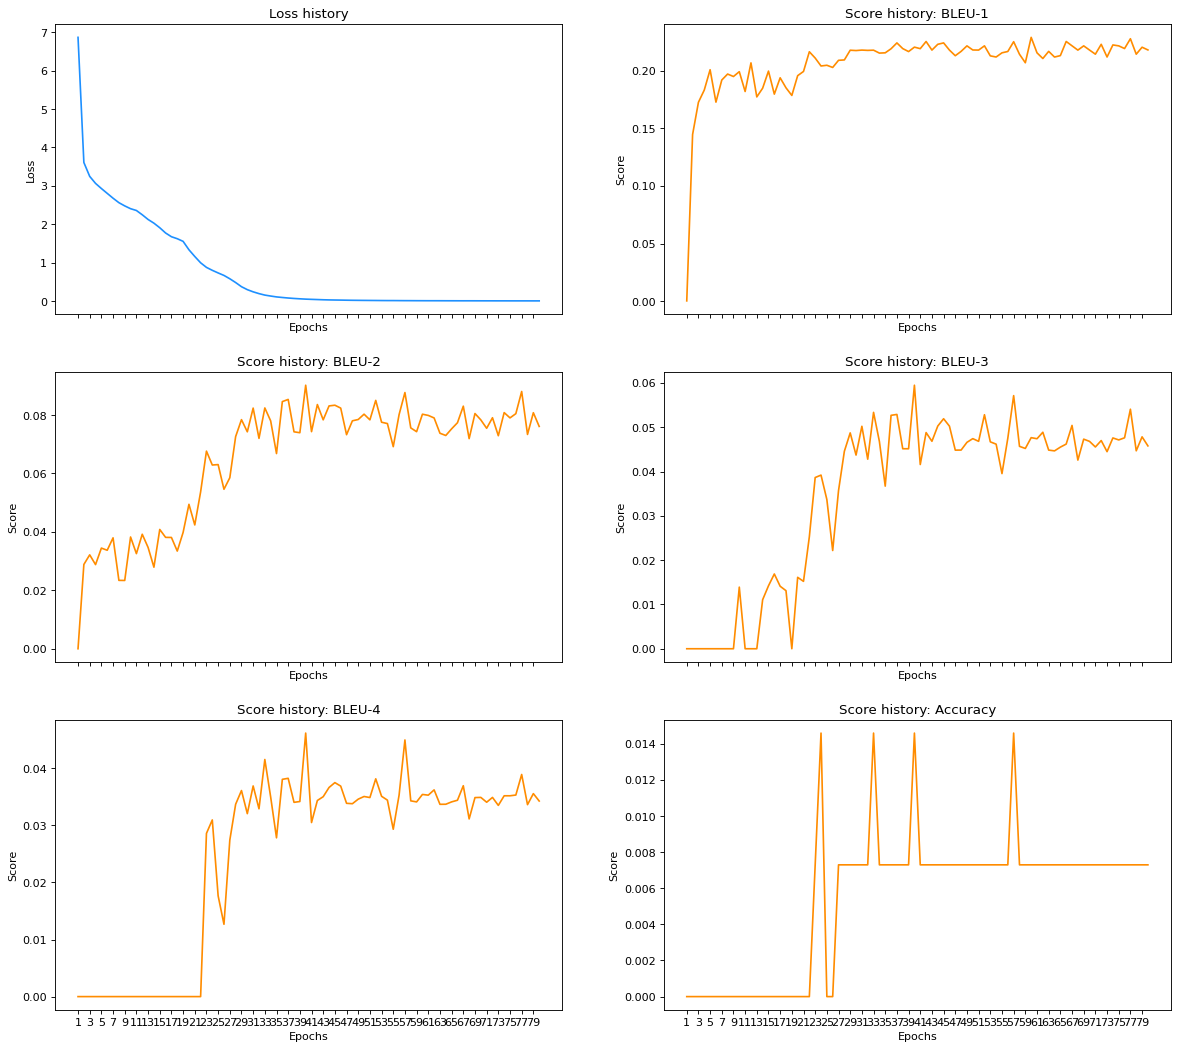

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

nrows = 3
ncols = 2

fig, ax = plt.subplots(nrows, ncols, sharex=True, figsize=(18, 16), dpi= 80,)

epochs = list(range(1, epoch+2))
epochs_ticks = list(range(1, epoch+2, 2))

i = 0
j = 0

ax[i][j].plot(epochs, loss_history, color='dodgerblue')
ax[i][j].set_title('Loss history')
ax[i][j].set_xlabel('Epochs')
ax[i][j].set_xticks(epochs_ticks)
ax[i][j].set_ylabel('Loss')

for name in score_functions.keys():
    j += 1
    if j >= ncols:
        j = 0
        i += 1
    score_history = [s[name] for s in scores_history]
    ax[i][j].plot(epochs, score_history, color='darkorange')
    ax[i][j].set_title('Score history: {}'.format(name))
    ax[i][j].set_xlabel('Epochs')
    ax[i][j].set_xticks(epochs_ticks)
    ax[i][j].set_ylabel('Score')

plt.show()

In [21]:
examples = zip(dev_source[:10], dev_target[:10], x_development[:10])
for source, target, x in examples:
    y = model(x.unsqueeze(0))
    translation = ' '.join(target_vocab.unidex_words(y[1:-1]))
    source = ' '.join(source)
    references = '\n'.join([' '.join(t) for t in target])

    print('Source: "{}"\nReferences:\n{}\nTranslation: "{}"\n'.format(source, references, translation))

Source: "i have absolutely no clue ."
References:
sina habari kamwe .
Translation: "tutaishughulikia ."

Source: "only the paranoid survive ."
References:
wale wenye wasiwasi ndio huishi .
Translation: "ilifanyika ."

Source: "my teacher is mrs . li ."
References:
mwalimu wangu ni bi . li
Translation: "rafiki yangu alinialika kwa chajio ."

Source: "they went on a voyage ."
References:
wamesafiri .
Translation: "wawindaji waliamka kabla ya macheo ."

Source: "millie has blue eyes ."
References:
millie ana macho ya bluu .
Translation: "millie ana macho ya kijani ."

Source: "there ' s always something to do here ."
References:
kila wakati kuna kitu cha kufanya hapa .
Translation: "kuna kitu sio kwangu ."

Source: "i ' d better go , too ."
References:
ni bora nami niondoke .
Translation: "ninaenda katika safari ."

Source: "there ' s no reason to be afraid ."
References:
hakuna sababu ya kuogopa .
Translation: "kuna mahali kwa kila mtu ."

Source: "a small gain is better than a great los

In [22]:
test_scores = score(best_model, x_test, test_target)
scores_str = '\n'.join(['{}: {:.4f}'.format(name, score) for name, score in test_scores.items()])
print('Final score:\n' + scores_str)

Scoring...:   0%|          | 0/322 [00:00<?, ?it/s]

Final score:
BLEU-1: 0.2371
BLEU-2: 0.0819
BLEU-3: 0.0421
BLEU-4: 0.0242
Accuracy: 0.0062
